# Results analysis

#### dataset Loading and options 

In [22]:
from datasets import Dataset,load_dataset
import pandas as pd
import seaborn as sb

dataset_split = ["simpleLLM_benchmark_llama3.18binstant_t_0.7"][0]

dataset = load_dataset("CharlyR/varbench-evaluation", "tikz", split=dataset_split)


In [23]:
dataset

Dataset({
    features: ['id', 'code', 'instruction', 'result_description', 'difficulty', 'patch', 'code_solution', 'image_solution', 'image_input', 'predictions', 'images_result', 'parsing_score', 'compiling_score', 'ChrfMetric', 'LPIPSMetric', 'FeatureMatchMetric', 'ClipTextMetric', 'LineMetric', 'MSSSIMMetric', 'TERMetric', 'PSNRMetric', 'BleuMetric', 'ClipImageMetric', 'var_score', 'index_best_prediction', 'best_ChrfMetric', 'best_LPIPSMetric', 'best_FeatureMatchMetric', 'best_ClipTextMetric', 'best_LineMetric', 'best_MSSSIMMetric', 'best_TERMetric', 'best_PSNRMetric', 'best_BleuMetric', 'best_ClipImageMetric'],
    num_rows: 50
})

## Best prediction computation

In [24]:
from results_utils import MetricPolicy


computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric") and not metric_name.startswith("best")
]


# each metric is computed on list of predictions of length pass@k, and yields a list of list of result of the same length.
# from that list[list[float]](the results), we get the best result according to a certain policy(here the arithmetic mean)
subset = dataset.map(
    MetricPolicy.compute_best_prediction,
    fn_kwargs={"computed_metrics_names": computed_metrics_names},
)

scores = {
    metric_name: sum(subset[f"best_{metric_name}"]) / len(subset)
    for metric_name in computed_metrics_names
}
scores["var_score"] = sum(subset["var_score"]) / len(subset)
scores
result_df = subset.to_pandas()

## Pre-Filtering

In [25]:
# filtering by having a result
filtered_df = result_df[result_df["index_best_prediction"] != -1]

# ordering by text metrics
text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = text_metrics + other_metrics
filtered_df = filtered_df[ordered_metrics + ["id", "difficulty"]]
filtered_df

,ChrfMetric,LineMetric,TERMetric,BleuMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric,MSSSIMMetric,FeatureMatchMetric,id,difficulty
0,[98.82567],[0.0],[97.78481],[97.86499],[45.181442],[99.58755],[22.200275],[99.85918],[97.17392],[58.44156],donkey_higher_mane,hard
1,[92.2547],[0.0],[83.60656],[87.232475],[43.536983],[97.35404],[24.78446],[95.02149],[88.22751],[62.162163],chimpanzee_squint_crosseyes,medium
2,[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[27.442713],[100.0],[100.0],[100.0],bee_red_stripes,easy
3,[96.58736],[0.0],[73.140495],[82.99074],[54.55823],[99.75662],[25.336811],[99.37684],[99.63105],[93.478264],shark_no_teeth,easy
4,[88.86572],[0.0],[80.606064],[87.083885],[48.234116],[97.826614],[26.552582],[99.55563],[96.84733],[72.58064],shark_other_set_pectoral_fin,hard
5,[98.48025],[0.0],[91.46342],[92.41655],[47.829006],[97.82557],[23.243683],[96.87161],[94.84958],[58.064518],dog_red_eyes,easy
7,[99.13497],[0.0],[98.31933],[98.72608],[41.423878],[97.0819],[25.911617],[99.51401],[87.44379],[38.55422],squid_bigger_eyes,medium
8,[96.893456],[0.0],[96.02273],[97.14141],[35.607243],[95.38803],[28.118896],[93.24947],[82.16467],[40.0],chimpanzee_blue_fur,easy
9,[97.752525],[0.0],[94.17476],[97.169106],[44.33442],[99.59982],[25.674559],[99.36806],[97.8831],[76.74419],cow_longer_horns,medium
11,[97.63793],[50.0],[93.57798],[95.57393],[35.269596],[93.31837],[26.930805],[95.7173],[57.1959],[35.555557],cat_big,medium


In [26]:
from results_utils import flatten_metrics
#flattening the pass arrays
flatten_df = flatten_metrics(filtered_df,ordered_metrics)

In [27]:
flatten_df

,ChrfMetric,LineMetric,TERMetric,BleuMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric,MSSSIMMetric,FeatureMatchMetric,difficulty,id
0,98.825668,0.0,97.784813,97.864990,45.181442,99.587547,22.200275,99.859177,97.173920,58.441559,hard,donkey_higher_mane
1,92.254700,0.0,83.606560,87.232475,43.536983,97.354042,24.784460,95.021492,88.227509,62.162163,medium,chimpanzee_squint_crosseyes
2,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,27.442713,100.000000,100.000000,100.000000,easy,bee_red_stripes
3,96.587357,0.0,73.140495,82.990738,54.558231,99.756622,25.336811,99.376839,99.631050,93.478264,easy,shark_no_teeth
4,88.865723,0.0,80.606064,87.083885,48.234116,97.826614,26.552582,99.555634,96.847328,72.580643,hard,shark_other_set_pectoral_fin
5,98.480247,0.0,91.463417,92.416550,47.829006,97.825569,23.243683,96.871613,94.849579,58.064518,easy,dog_red_eyes
6,99.134972,0.0,98.319328,98.726082,41.423878,97.081902,25.911617,99.514008,87.443787,38.554218,medium,squid_bigger_eyes
7,96.893456,0.0,96.022728,97.141411,35.607243,95.388031,28.118896,93.249474,82.164673,40.000000,easy,chimpanzee_blue_fur
8,97.752525,0.0,94.174759,97.169106,44.334419,99.599823,25.674559,99.368057,97.883102,76.744186,medium,cow_longer_horns
9,97.637932,50.0,93.577980,95.573929,35.269596,93.318367,26.930805,95.717300,57.195900,35.555557,medium,cat_big


## no subcategories

<Axes: >

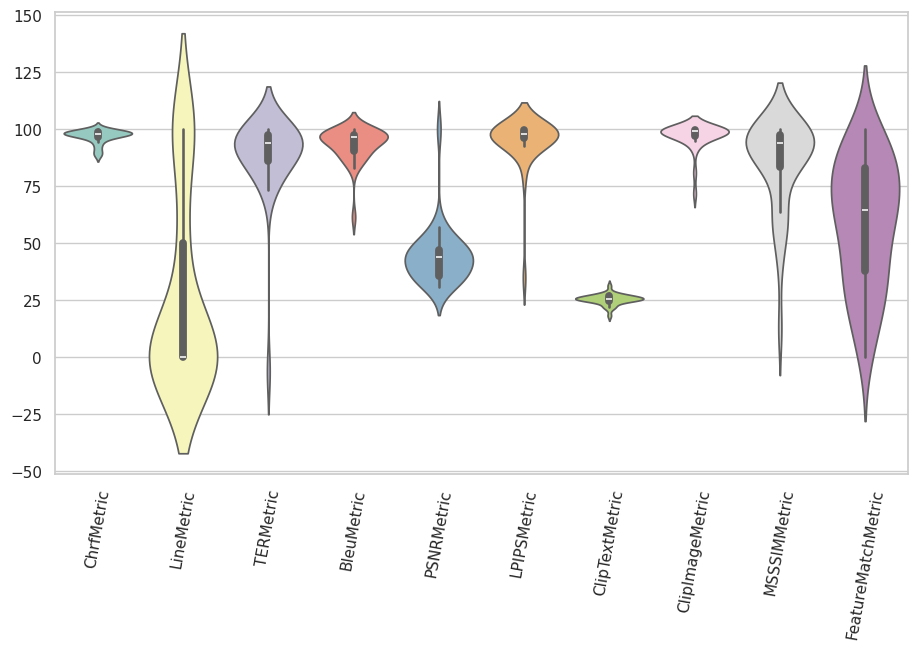

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=80)

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=flatten_df, palette="Set3")


<Axes: >

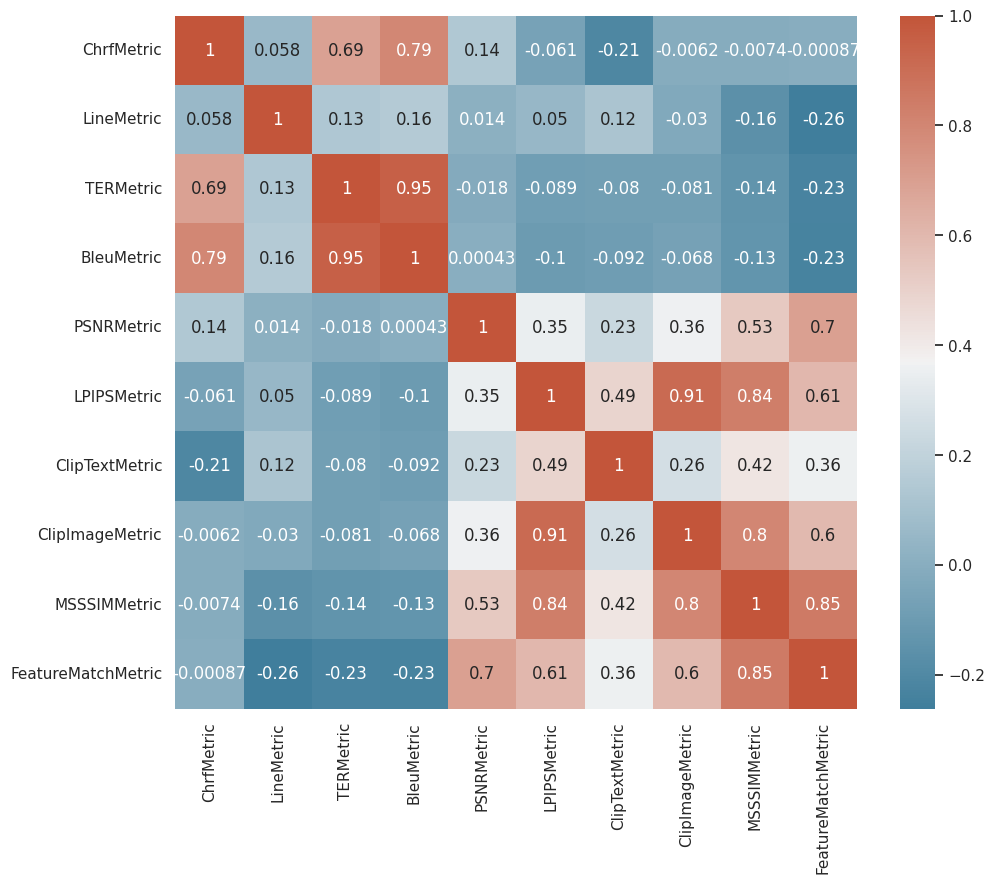

In [29]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = flatten_df.select_dtypes(["int","float"]).corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, annot=True)

## filtered by difficulty

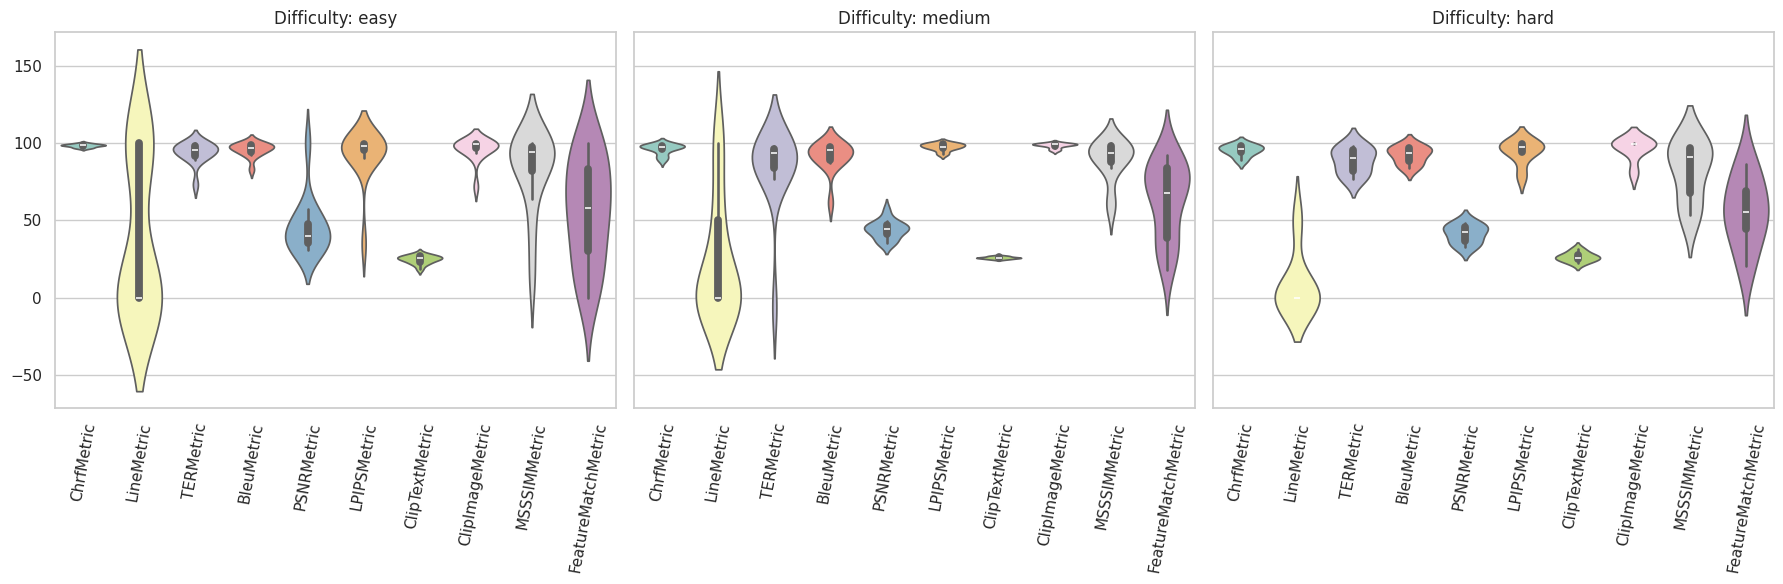

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

df_difficulty = flatten_df.drop("id",axis=1)
df_difficulty

sns.set_theme(style="whitegrid")

# Assuming 'difficulty' column exists in the DataFrame
difficulties = ['easy', 'medium', 'hard']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Create 3 subplots

for i, difficulty in enumerate(difficulties):
    sns.violinplot(
        data=df_difficulty[df_difficulty['difficulty'] == difficulty], 
        ax=axes[i], 
        palette="Set3"
    )
    axes[i].set_title(f'Difficulty: {difficulty}')
    axes[i].tick_params(axis='x', rotation=80)

plt.tight_layout()
plt.show()


In [36]:
df_difficulty['difficulty'] = pd.Categorical(df_difficulty['difficulty'], categories=['easy', 'medium', 'hard'], ordered=True)
averages = df_difficulty.groupby('difficulty',observed=True).mean()
averages

,ChrfMetric,LineMetric,TERMetric,BleuMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric,MSSSIMMetric,FeatureMatchMetric
difficulty,,,,,,,,,,
easy,98.402107,38.461540,93.809158,95.797966,45.901157,92.179939,24.622536,95.885948,81.325592,55.618263
medium,96.212021,23.076923,83.081795,91.348503,43.995136,97.571426,25.827127,98.429779,88.791618,63.256260
hard,95.312653,8.333333,88.604530,92.252327,41.223980,94.480591,26.348265,96.440422,81.785194,55.342381


In [37]:
med = df_difficulty.groupby('difficulty',observed=True).median()
med

,ChrfMetric,LineMetric,TERMetric,BleuMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric,MSSSIMMetric,FeatureMatchMetric
difficulty,,,,,,,,,,
easy,98.591225,0.0,95.569618,97.084702,39.844341,97.825569,25.336811,99.264832,93.997589,58.064518
medium,97.637932,0.0,93.577980,95.573929,44.334419,97.587921,25.674559,99.084465,93.516449,67.567566
hard,96.134644,0.0,90.208466,93.724854,42.685886,97.631889,25.860937,99.546127,90.685020,55.262444
